This notebook is example of preprocessing steps before training.

First some imports

In [1]:
import numpy as np
import xarray as xr
import cv2
import matplotlib.pyplot as plt


Then open files and rearrange them so that channels are last axis. 

Rotation is the number of different possible rotations.

In [2]:
crop_size = 256
rotation = 16
reflection = True

image = xr.open_rasterio('../input_marras2018/patched_summer_2017.nc')
mask = xr.open_rasterio('../input_marras2018/lopulliset_tavoiteluokat.nc')
img = np.swapaxes(image.values, 0, 2)
msk = mask[0].values
img = img.swapaxes(0,1)
indices = xr.open_rasterio('../input_marras2018/kaakonkulma_s2ind_20170601_20170831_rp.img').values.swapaxes(0,2)
indices = indices.swapaxes(0,1)

C:\Users\E1005164\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\rasterio\__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


Check that shapes match

In [3]:
img.shape, msk.shape, indices.shape

((6477, 7068, 9), (6477, 7068), (6477, 7068, 5))

Stack band and spectral index data into one image

In [4]:
img = np.dstack((img, indices))

Spectral indices have some invalid data on the borders, so crop images by 500 pixels on each side

In [5]:
img = img[500:-500,500:-500,:]
msk = msk[500:-500,500:-500]

Following few cells test that real-time augmentation (rotations, flips etc) work

In [6]:
angle = 360. * np.random.randint(0, rotation) / rotation
radian = 2.*np.pi * angle / 360.
crop_size_new = int(np.ceil(float(crop_size) * (abs(np.sin(radian)) + 
                                                abs(np.cos(radian)))))
rot_mtx = cv2.getRotationMatrix2D((float(crop_size_new) / 2.,
                                  float(crop_size_new) / 2.),
                                  angle, 1.)
crop_diff = int((crop_size_new - crop_size)/2.)
print(angle, radian, crop_size_new, crop_diff)
rot_mtx

112.5 1.9634954084936207 335 39


array([[-3.82683432e-01,  9.23879533e-01,  7.68496532e+01],
       [-9.23879533e-01, -3.82683432e-01,  3.86349297e+02]])

In [7]:
x_base = np.random.randint(0, 1000 - crop_size_new)
y_base = np.random.randint(0, 1000 - crop_size_new)
img_crop = np.squeeze(img[x_base: x_base + crop_size_new, y_base: y_base + crop_size_new, :])
msk_crop = np.squeeze(msk[x_base: x_base + crop_size_new, y_base: y_base + crop_size_new])

In [8]:
img_rot = cv2.warpAffine(img_crop, rot_mtx, (crop_size_new, crop_size_new))
msk_rot = cv2.warpAffine(msk_crop, rot_mtx, (crop_size_new, crop_size_new))

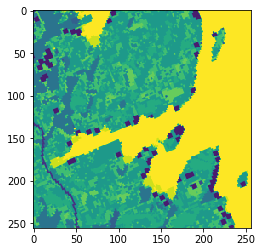

In [15]:
plt.imshow(msk_rot[crop_diff: crop_diff+crop_size:, crop_diff: crop_diff+crop_size:])

In [10]:
img_final = img_rot[crop_diff: crop_diff+crop_size:, crop_diff: crop_diff+crop_size:, :]
img_final.shape

(256, 256, 14)

In [11]:
def show_image(vals):
    rgbview = np.empty((vals.shape[0], vals.shape[1],3))
    rgbview[...,0] = vals[...,2] / 2000
    rgbview[...,1] = vals[...,1] / 2000
    rgbview[...,2] = vals[...,0] / 2000
    plt.imshow(rgbview)

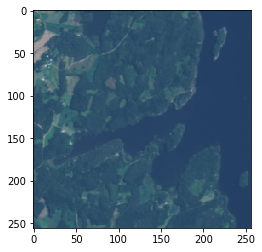

In [12]:
show_image(img_final)

Then extract ten different images from larger scene, assing 8 of them to be training set and 2 validation. Selection process is rather random.

In [85]:
train_data = np.empty((8, 850,850,14))
val_data = np.empty((2, 850,850,14))
train_mask = np.empty((8, 850,850))
val_mask = np.empty((2,850,850))

In [86]:
val_data[0] = img[1000:1850, 2200:3050,:]
val_mask[0] = msk[1000:1850,2200:3050]
val_data[1] = img[:850,4400:5250,:]
val_mask[1] = msk[:850,4400:5250]

In [89]:
train_data[0] = img[250:1100,250:1100,:]
train_mask[0] = msk[250:1100,250:1100]
train_data[1] = img[4000:4850,250:1100,:]
train_mask[1] = msk[4000:4850,250:1100]
train_data[2] = img[1500:2350,1500:2350,:]
train_mask[2] = msk[1500:2350,1500:2350]
train_data[3] = img[1100:1950,600:1450,:]
train_mask[3] = msk[1100:1950,600:1450]
train_data[4] = img[1500:2350,3200:4050,:]
train_mask[4] = msk[1500:2350,3200:4050]
train_data[5] = img[100:950,2200:3050,:]
train_mask[5] = msk[100:950,2200:3050]
train_data[6] = img[400:1250,2800:3650,:]
train_mask[6] = msk[400:1250,2800:3650]
train_data[7] = img[3400:4250,800:1650,:]
train_mask[7] = msk[3400:4250,800:1650]

Zero-center and normalize all these images **based on training data**. These metrics are saved and used for full image classification, provided that test image has similar reflectance profile.

In [109]:
means = []
stds = []
train_data_norm = np.empty(train_data.shape)
val_data_norm = np.empty(val_data.shape)
for a in range(14):
    train_mean = np.mean(train_data[...,a])
    train_std = np.std(train_data[...,a])
    train_data_norm[...,a] = (train_data[...,a] - train_mean) / (train_std - 1e-8)
    val_data_norm[...,a] = (val_data[...,a] - train_mean) / (train_std - 1e-8)
    means.append(train_mean)
    stds.append(train_std)

In [112]:
import pickle
with open('updated_train_means.obj', 'wb') as vals:
    pickle.dump((means, stds), vals, protocol=pickle.HIGHEST_PROTOCOL) 

Then save these images for later use

In [116]:
for i in range(8):
    np.save(f'data/train_data_image_{i}.npy', train_data_norm[i].astype('float32'))
    np.save(f'data/train_masks_{i}.npy', train_mask[i].astype('float32'))
for i in range(2):
    np.save(f'data/val_data_image_{i}.npy', val_data_norm[i].astype('float32'))
    np.save(f'data/val_masks_image_{i}.npy', val_mask[i].astype('float32'))